# Test loading model from keras file

In this notebook I test loading trained model to make sure that it gives correct backtesting result. 

Then, I check getting the most recent indicators available in economic calendar and calculating portfolio weights from pre-trained model for today.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from keras.models import load_model
import os
os.chdir(os.path.expanduser('../'))

from helper_functions import run_full_backtesting

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

days_to_recalculate = data_provider.get_days_to_recalculate()
backtesting_start_idx = 58
dates_for_test = days_to_recalculate[-backtesting_start_idx:]

In [4]:
x_test = []
for date in dates_for_test:
    principal_component_df = data_provider.calculate_principal_component_from_calendar(
        date, no_months=6)
    x_test.append(principal_component_df.values)

x_test = np.array(x_test)
x_test.shape

(58, 6, 27)

In [5]:
loaded_dnn_model = load_model('daily_dnn_model_from_calendar.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


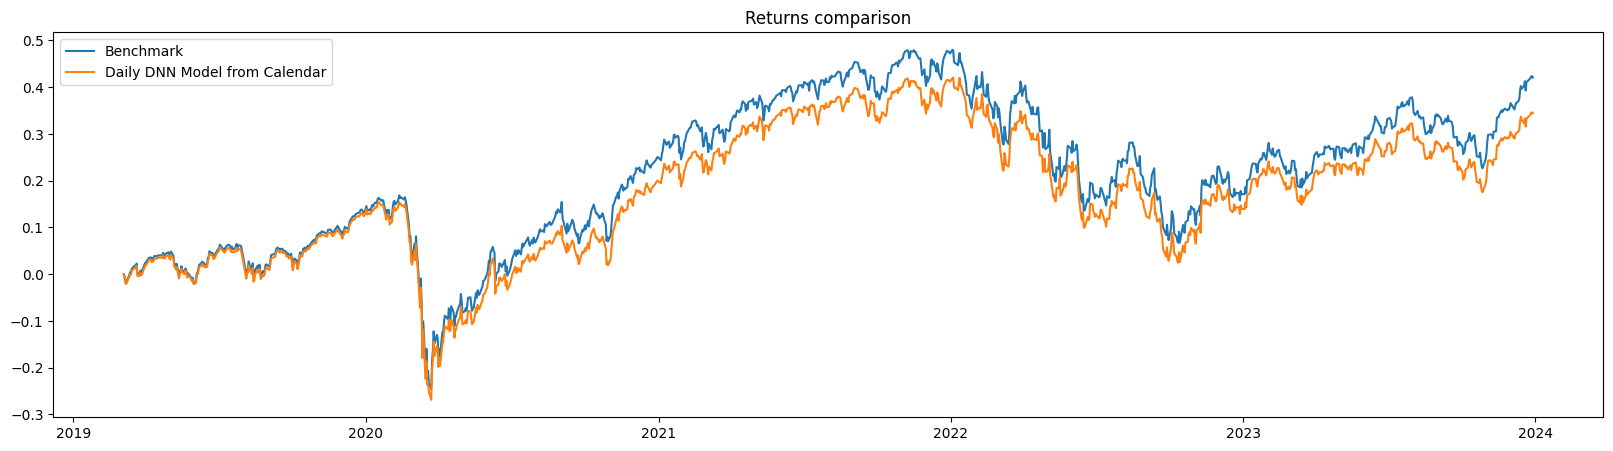

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.0768,0.2033,0.3775,0.442,-0.3548,500.0,0.2163,0.000
Daily DNN Model from Calendar,0.0640,0.2023,0.3165,0.368,-0.3666,499.0,0.1746,-0.578


In [6]:
models = {
    'Daily DNN Model from Calendar': (loaded_dnn_model, x_test),
}

df_results = run_full_backtesting(data_provider, models)
df_results

Backtesting returns exactly the same results and trained model

## Test calculate weights for today

Testing code that will be used to deploy the investment algorithm to AWS Lambda function

In [7]:
read_date = datetime.today().date()
no_months = 6
limit_date = (read_date - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
print('Reading indicators from', limit_date, 'to', read_date)

data_provider = DataProvider()
# We need to initialize correlations to fill missing values
data_provider.initialize_current_correlations(limit_date, read_date)
x_today = data_provider.calculate_principal_component_from_calendar(
    read_date, no_months, limit_date)
x_today = x_today.values.reshape(1, 6, 27)

loaded_dnn_model = load_model('daily_dnn_model_from_calendar.keras')
predicted_weights = loaded_dnn_model.predict(x_today)
predictions = pd.Series(predicted_weights[0], 
                        index=data_provider.selected_countries)
predictions['Russia'] = 0 # Russia is uninvertible after 02/2022
predictions = predictions/predictions.sum()
predictions

Reading indicators from 2023-06-08 to 2024-06-08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


United States     0.509795
Japan             0.071387
United Kingdom    0.062240
Canada            0.036376
France            0.026851
Switzerland       0.027230
Germany           0.024352
Australia         0.027626
Netherlands       0.010368
Sweden            0.009655
Hong Kong         0.012496
Spain             0.009750
Italy             0.010007
Singapore         0.010496
Denmark           0.010119
Finland           0.010005
Belgium           0.010720
Norway            0.009313
China             0.024250
Taiwan            0.013988
India             0.011840
Korea             0.016648
Brazil            0.011626
Russia            0.000000
South Africa      0.010490
Mexico            0.012842
Malaysia          0.009529
dtype: float32